In [1]:
import bz2
import numpy as np
import nltk
import re
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Google Drive Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training and Test Dataset Import

In [3]:
train = bz2.BZ2File("/content/drive/My Drive/amazon/train.ft.txt.bz2/train.ft.txt.bz2")

In [4]:
test = bz2.BZ2File("/content/drive/My Drive/amazon/test.ft.txt.bz2/test.ft.txt.bz2")

In [5]:
train = train.readlines()
test = test.readlines()

In [6]:
print("Number of training reviews: " + str(len(train)))
print("Number of training reviews: " + str(len(test)))

Number of training reviews: 3600000
Number of training reviews: 400000


In [7]:
num_train = 40000
num_test = 10000

train = [x.decode('utf-8') for x in train[:num_train]]
test = [x.decode('utf-8') for x in test[:num_test]]

Extracting Labels from Sentences
- 1 for positive reviews
- 0 for negative reviews

In [8]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train]

In [9]:
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test]

Cleaning

In [10]:
for i in range(len(train_sentences)):
  train_sentences[i] = re.sub('\d','0',train_sentences[i])

In [11]:
for i in range(len(test_sentences)):
  test_sentences[i] = re.sub('\d','0',test_sentences[i])

Modify URL

In [12]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

In [13]:
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

Tokenisation

In [14]:
words = Counter()

for i, sentence in enumerate(train_sentences):
    train_sentences[i] = []
    for word in nltk.word_tokenize(sentence): 
        words.update([word.lower()]) 
        train_sentences[i].append(word)
    if i%100 == 0:
        print(str((i*100)/num_train) + "% done")
print("100% done")

0.0% done
0.25% done
0.5% done
0.75% done
1.0% done
1.25% done
1.5% done
1.75% done
2.0% done
2.25% done
2.5% done
2.75% done
3.0% done
3.25% done
3.5% done
3.75% done
4.0% done
4.25% done
4.5% done
4.75% done
5.0% done
5.25% done
5.5% done
5.75% done
6.0% done
6.25% done
6.5% done
6.75% done
7.0% done
7.25% done
7.5% done
7.75% done
8.0% done
8.25% done
8.5% done
8.75% done
9.0% done
9.25% done
9.5% done
9.75% done
10.0% done
10.25% done
10.5% done
10.75% done
11.0% done
11.25% done
11.5% done
11.75% done
12.0% done
12.25% done
12.5% done
12.75% done
13.0% done
13.25% done
13.5% done
13.75% done
14.0% done
14.25% done
14.5% done
14.75% done
15.0% done
15.25% done
15.5% done
15.75% done
16.0% done
16.25% done
16.5% done
16.75% done
17.0% done
17.25% done
17.5% done
17.75% done
18.0% done
18.25% done
18.5% done
18.75% done
19.0% done
19.25% done
19.5% done
19.75% done
20.0% done
20.25% done
20.5% done
20.75% done
21.0% done
21.25% done
21.5% done
21.75% done
22.0% done
22.25% done
22.5%

Remove typs and words than appear only once

In [15]:
# Removing the words that only appear once
words = {k:v for k,v in words.items() if v>1}
# Sorting the words according to the number of appearances, with the most common word being first
words = sorted(words, key=words.get, reverse=True)
# Adding padding and unknown to our vocabulary so that they will be assigned an index
words = ['_PAD','_UNK'] + words
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

Mapping
- Convert the words in the sentences to their corresponding indexes

In [16]:
for i, sentence in enumerate(train_sentences):
  train_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

In [17]:
for i, sentence in enumerate(test_sentences):
  test_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

Padding

*   Set the length





In [18]:
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length

def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [19]:
seq_len = 200

train_sentences = pad_input(train_sentences, seq_len)
test_sentences = pad_input(test_sentences, seq_len)

In [20]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Validation set

In [21]:
split_frac = 0.5
split_id = int(split_frac * len(test_sentences))
val_sentences, test_sentences = test_sentences[:split_id], test_sentences[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

PyTorch

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 40

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [23]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [24]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print(sample_x.shape, sample_y.shape)

torch.Size([40, 200]) torch.Size([40])


LSTM

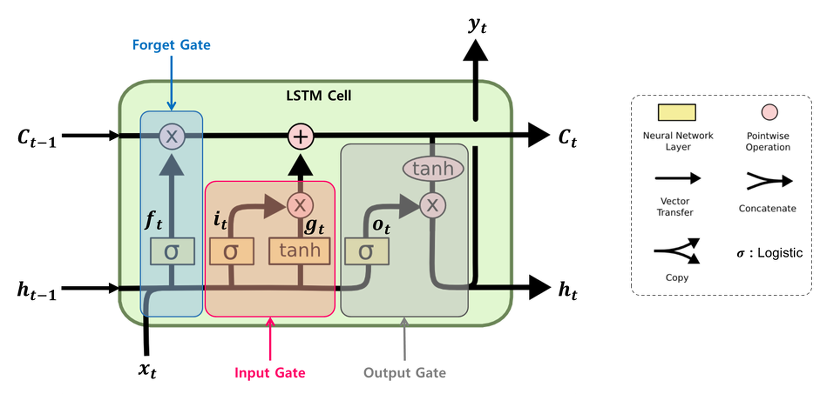

In [ ]:
import torch.nn as nn

class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [ ]:
vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 512
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model)

SentimentNet(
  (embedding): Embedding(225965, 400)
  (lstm): LSTM(400, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 2
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), '../working/state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

In [ ]:
model.load_state_dict(torch.load('../working/state_dict.pt'))

In [ ]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

GRU

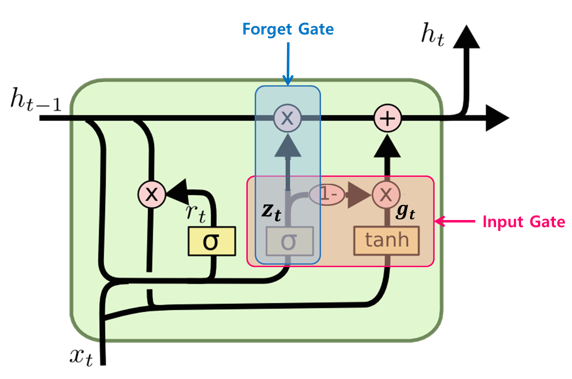

In [25]:
import torch.nn as nn
class GRUNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(GRUNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        GRU_out, hidden = self.gru(embeds, hidden)
        GRU_out = GRU_out.contiguous().view(-1,self.hidden_dim)
        
        out = self.dropout(GRU_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [26]:
vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 512
n_layers = 2

model = GRUNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
epochs = 2
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = h.data
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = val_h.data
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/2... Step: 500... Loss: 0.263638... Val Loss: 1.090557
Validation loss decreased (inf --> 1.090557).  Saving model ...
Epoch: 1/2... Step: 1000... Loss: 0.343212... Val Loss: 1.029881
Validation loss decreased (1.090557 --> 1.029881).  Saving model ...
Epoch: 2/2... Step: 1500... Loss: 0.198962... Val Loss: 1.263056
Epoch: 2/2... Step: 2000... Loss: 0.311458... Val Loss: 1.210171


In [28]:
# Loading the best model GRU
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = h.data
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 1.017
Test accuracy: 50.320%
